This is the third post in an exercise to predict post popularity on a NYTimes website. Two previous post described fitting a simple Random Forest model and theory behind the need for feature selection (or feature reduction):
- [Naïve Random Forest Classifier](http://r-train.ru/naive-random-forest-classifier/)
- [Fitting models on low signal-to-noise data](http://r-train.ru/fitting-models-on-low-signal-to-noise-data/)  

Though theoretically the need for feature selection is well proved and a devoted module exist in `sklearn` with a name `feature_selection`, practically it's not quite clear to what extent feature selection is needed in different models.  

Max Kuhn, e.g., the author of machine learning `caret` package for R [writes](http://topepo.github.io/caret/featureselection.html):

> Many models that can be accessed using caret's train function produce prediction equations that do not necessarily use all the predictors. These models are thought to have built-in feature selection: ada, bagEarth, bagFDA, bstLs, bstSm, C5.0, C5.0Cost, C5.0Rules, C5.0Tree, cforest, ctree, ctree2, cubist, earth, enet, evtree, extraTrees, fda, gamboost, gbm, gcvEarth, glmnet, glmStepAIC, J48, JRip, lars, lars2, lasso, LMT, LogitBoost, M5, M5Rules, nodeHarvest, oblique.tree, OneR, ORFlog, ORFpls, ORFridge, ORFsvm, pam, parRF, PART, penalized, PenalizedLDA, qrf, relaxo, rf, rFerns, rpart, rpart2, rpartCost, RRF, RRFglobal, smda, sparseLDA. Many of the functions have an ancillary method called predictors that returns a vector indicating which predictors were used in the final model.

> In many cases, using these models with built-in feature selection will be more efficient than algorithms where the search routine for the right predictors is external to the model. Built-in feature selection typically couples the predictor search algorithm with the parameter estimation and are usually optimized with a single objective function (e.g. error rates or likelihood).

Note, that Random Forest per se is not a model with internal feature selection.

In this post I will try several methods (linear and non-linear) with internal feature selection and see if combining them with Random Forest can improve AUC=0.92616 achieved on the [first attempt](http://r-train.ru/naive-random-forest-classifier/).

The plan is as follows: 

1. Repeat preprocessing as [before](http://r-train.ru/naive-random-forest-classifier/)
2. Try several different feature selection approaches, namely:
    - univariate feature selection
    - try `RandomizedLogisticRegression` function from `sklearn.linear_model`
    - try adhoc Randomized Logistic Regression with different penalties (l1 vs l2) and regularizing params (C)
    - try randomized SVM with different combinations of l1,l2 and C
3. Tune Random Forest on reduced set of features and see which reduction approach would perform best

## Preprocess data

Load data

In [1]:
import numpy as np
import pandas as pd
seed = 1
train = pd.read_csv('/home/sergey/R_Analyttics_Edge_MITx/kaggle/NYTimesBlogTrain.csv')
test = pd.read_csv('/home/sergey/R_Analyttics_Edge_MITx/kaggle/NYTimesBlogTest.csv')
combo = pd.merge(train, test, how='outer')
combo = combo.drop('Popular', axis=1)
y = train['Popular']
combo_clean = combo.fillna('empty')
combo_clean['LogWC'] = np.log(.1+ combo_clean['WordCount'])

Extract Date/time info and bin time

In [2]:
import datetime as dt
combo_clean['date'] = combo_clean['PubDate'].apply(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%A')
)
combo_clean['hour'] = combo_clean['PubDate'].apply(
    lambda x: int(dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%H'))
)
combo_clean[['PubDate','date','hour']][1:5]
bins = np.linspace(0,24,5)
labels = ['night', 'morning', 'afternoon', 'evening']
combo_clean['hour_bins'] = pd.cut(combo_clean['hour'], bins=bins, labels=labels)
combo_clean.drop(['hour', 'WordCount', 'PubDate'], axis=1, inplace=True)

Make dummies and bags of words

In [3]:
import sklearn.feature_extraction.text as txt
categorical_dummies = pd.get_dummies(combo_clean[['NewsDesk','SectionName','SubsectionName','date', 'hour_bins']])
categorical_dummies.shape
tfidf = txt.TfidfVectorizer(stop_words='english', min_df=10, ngram_range=(1, 2),)
tfidf
bwHeadline       = (tfidf.fit_transform(combo_clean['Headline'])).todense()
bwHeadline_names = np.asarray(tfidf.get_feature_names())
bwHeadline_names = np.core.defchararray.add('H_', bwHeadline_names)
bwAbstract       = (tfidf.fit_transform(combo_clean['Abstract'])).todense()
bwAbstract_names = np.asarray(tfidf.get_feature_names())
bwAbstract_names = np.core.defchararray.add('A_', bwAbstract_names)

Put everything together

In [4]:
data = np.concatenate((categorical_dummies, bwHeadline, bwAbstract), axis=1)
feature_names = np.concatenate((categorical_dummies.columns, bwHeadline_names, bwAbstract_names), axis=0)
data_train = data[: train.shape[0],:]
data_test  = data[train.shape[0]:,:]
import sklearn.cross_validation as cv
data_train, data_val, y_train, y_val = cv.train_test_split(data_train, y, test_size=.2, random_state=seed)

## Feature selection

In [5]:
import sklearn.feature_selection as slct
import sklearn.ensemble as ens
import sklearn.grid_search as gr

#### Univariate feature selection

First, let's try feature selection for classification on `chi2` score. Cross-validation used is 5-fold stratified shuffled sampling that ensures every time cv is run the folds are different. We cross-validate for best # of features left that will yield highest AUC.

In [66]:
cv_scores = []
for k in np.linspace(30,1030, 21):
    kbest_mod = slct.SelectKBest(slct.chi2, k=int(k))
    kbest_mod.fit(data_train, y_train)
    data_train_kbest = kbest_mod.transform(data_train)
    rf_mod = ens.ExtraTreesClassifier(n_estimators=500, random_state=seed, n_jobs=-1,
                                      bootstrap=True, class_weight='auto')
    folds = cv.StratifiedShuffleSplit(y=y_train, n_iter=5, test_size=.2, random_state=seed)
    cv_scores.append(cv.cross_val_score(rf_mod, data_train_kbest, y_train, scoring='roc_auc', cv=folds, n_jobs=-1))

Then, the same is done on `f_classif`, which are actually F scores.

In [67]:
cv_scores_f = []
for k in np.linspace(30,1030,21):
    kbest_mod = slct.SelectKBest(slct.f_classif, k=int(k))
    kbest_mod.fit(data_train, y_train)
    data_train_kbest = kbest_mod.transform(data_train)
    etc_mod = ens.ExtraTreesClassifier(n_estimators=500, random_state=seed, n_jobs=-1,
                                      bootstrap=True, class_weight='auto')
    folds = cv.StratifiedShuffleSplit(y=y_train, n_iter=5, test_size=.2, random_state=seed)
    cv_scores_f.append(cv.cross_val_score(etc_mod, data_train_kbest, y_train, scoring='roc_auc', cv=3, n_jobs=-1))

/home/sergey/anaconda3/lib/python3.4/site-packages/sklearn/feature_selection/univariate_selection.py:111: UserWarning: Features [ 247  256  257  442  883 1473 1528 1623 1714 1731 1732 2345 2405 2406 2454
 2464 2547 2703 2819 3232] are constant.
  UserWarning)
/home/sergey/anaconda3/lib/python3.4/site-packages/sklearn/feature_selection/univariate_selection.py:111: UserWarning: Features [ 247  256  257  442  883 1473 1528 1623 1714 1731 1732 2345 2405 2406 2454
 2464 2547 2703 2819 3232] are constant.
  UserWarning)
/home/sergey/anaconda3/lib/python3.4/site-packages/sklearn/feature_selection/univariate_selection.py:111: UserWarning: Features [ 247  256  257  442  883 1473 1528 1623 1714 1731 1732 2345 2405 2406 2454
 2464 2547 2703 2819 3232] are constant.
  UserWarning)
/home/sergey/anaconda3/lib/python3.4/site-packages/sklearn/feature_selection/univariate_selection.py:111: UserWarning: Features [ 247  256  257  442  883 1473 1528 1623 1714 1731 1732 2345 2405 2406 2454
 2464 2547 2703 

Let's calculate means and std's of cross-validated AUC's, which will be fed later to plots of the metrics.

In [68]:
mean_chi = np.mean(cv_scores, axis=1)
std_chi  = np.std(cv_scores, axis=1)
mean_chi_lower = mean_chi - std_chi
mean_chi_higher = mean_chi + std_chi

In [69]:
mean_f = np.mean(cv_scores_f, axis=1)
std_f  = np.std(cv_scores_f, axis=1)
mean_f_lower=mean_f - std_f
mean_f_higher = mean_f + std_f

Let's plot the performance of two selection methods.

In [61]:
% matplotlib inline
import matplotlib.pyplot as plt

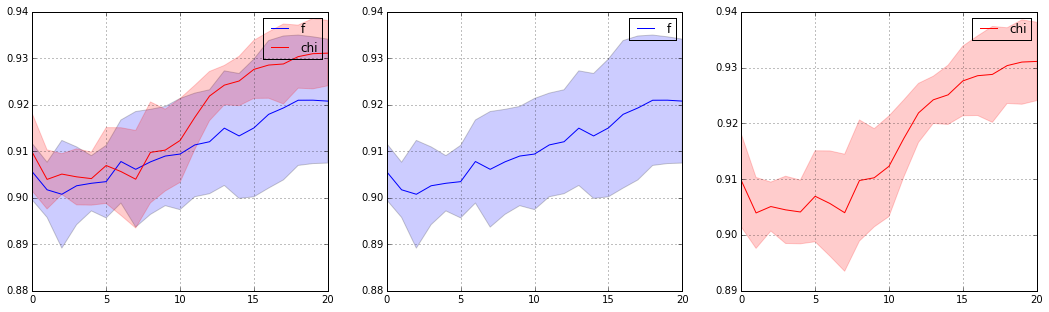

In [79]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(mean_f, 'b', label = 'f')
plt.fill_between(np.arange(len(mean_f)), mean_f_higher, mean_f_lower, alpha=.2)
plt.plot(mean_chi, 'r', label = 'chi')
plt.fill_between(np.arange(len(mean_chi)),mean_chi_higher, mean_chi_lower, color='r', alpha=.2)
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(mean_f, 'b', label = 'f')
plt.fill_between(np.arange(len(mean_f)), mean_f_higher, mean_f_lower, alpha=.2)
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(mean_chi, 'r', label = 'chi')
plt.fill_between(np.arange(len(mean_chi)),mean_chi_higher, mean_chi_lower, color='r', alpha=.2)
plt.legend()
plt.grid()
plt.show()

Feature selection on `chi2` score with 1030 features left appears to be the best model on training set.

## Validate on held-out set

Validation on `ExtraTreesClassifier`

In [81]:
kbest_mod = slct.SelectKBest(slct.chi2, k=1030)
kbest_mod.fit(data_train, y_train)
data_train_kbest = kbest_mod.transform(data_train)
data_val_kbest = kbest_mod.transform(data_val)

etc_mod = ens.ExtraTreesClassifier(n_estimators=3000, random_state=seed, n_jobs=-1,
                                      bootstrap=True, class_weight='auto')
etc_mod.fit(data_train_kbest, y_train)

ExtraTreesClassifier(bootstrap=True, class_weight='auto', criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=3000, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [82]:
import sklearn.metrics as mts
mts.roc_auc_score(y_val, etc_mod.predict_proba(data_val_kbest)[:,1])

0.90528396516027709

Validation on `RandomForestClassifier`

In [85]:
kbest_mod = slct.SelectKBest(slct.chi2, k=1030)
kbest_mod.fit(data_train, y_train)
data_train_kbest = kbest_mod.transform(data_train)
data_val_kbest = kbest_mod.transform(data_val)

rf_mod = ens.RandomForestClassifier(n_estimators=3000, random_state=seed, n_jobs=-1,
                                      bootstrap=True, class_weight='auto')
rf_mod.fit(data_train_kbest, y_train)

RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=3000, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [86]:
import sklearn.metrics as mts
mts.roc_auc_score(y_val, rf_mod.predict_proba(data_val_kbest)[:,1])

0.90412829299635888

## Summary

That was the first step in feature selection exercise: univariate feature selection on chi2 and f_classif (F score).  

After cross-vaidation, the best model seem to be that with 1030 features.  

For such a model, AUC validated on held-out set decreased from 0.92616 to 0.90528 for ExtraTreesClassifier and 0.90412 for RandomForestClassifier (both on 1030 features)